<a href="https://colab.research.google.com/github/NielsRogge/Transformers-Tutorials/blob/master/Flux/Run_Flux_on_an_8GB_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running Flux on an 8GB machine

In this notebook, we're going to showcase how to run the powerful [Flux](https://huggingface.co/docs/diffusers/main/en/api/pipelines/flux) model on a machine requiring only 8GB of GPU memory. This leverages the technique of [quantization](https://huggingface.co/docs/optimum/en/concept_guides/quantization), which means shrinking down the size of a model significantly with minimal impact on the performance.

This is based on the amazing work by the 🤗 Diffusers team, and [this tweet](https://x.com/ariG23498/status/1847926852398227967) by Aritra (go give [them](https://huggingface.co/sayakpaul) a [follow](https://huggingface.co/ariG23498)). Credits to them!

## Quick intro to Flux

Flux is an impressive text-to-image (and image-to-image) model by [Black Forest Labs](https://huggingface.co/black-forest-labs), the creators of [Stable Diffusion](https://huggingface.co/docs/diffusers/v0.14.0/en/stable_diffusion). Flux can be seen as the successor of Stable Diffusion, and incorporates many advancements in the field, including:
* the use of 2 pre-trained text encoders (CLIP and T5)
* the use of a Transformer-based [DiT](https://github.com/facebookresearch/DiT) model for denoising
* the use of a variational auto-encoder ([VAE](https://arxiv.org/abs/1906.02691)) to perform the denoising in a latent space, rather than in pixel space (similar to Stable Diffusion).

<img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/flux_architecture.webp"
alt="drawing" width="600"/>

<small> Flux model architecture. Taken from <a href="https://www.reddit.com/r/LocalLLaMA/comments/1ekr7ji/fluxs_architecture_diagram_dont_think_theres_a/">Reddit.</a> </small>

The use of 2 pre-trained text encoders (as seen at the bottom of the diagram) makes it a lot better at understanding prompts and rendering text within images.

The authors released various variants of Flux:

* [Flux-Schnell](https://huggingface.co/black-forest-labs/FLUX.1-schnell), an open-source model available on Hugging Face (distilled from the larger variants).
* [Flux-Dev](https://huggingface.co/black-forest-labs/FLUX.1-dev), an open model available on Hugging Face, but with a non-permissive license
* [Flux-Pro](https://blackforestlabs.ai/#get-flux), a closed-source model only accessible via various APIs.

## Set-up environment

Make sure to set your runtime to "GPU" (I've tested it on both NVIDIA T4 and NVIDIA L4 GPUs). You can check that a GPU is active by running the `nvidia-smi` command:

In [1]:
!nvidia-smi

Mon Nov  4 11:55:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.09                 Driver Version: 561.09         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8              1W /   80W |       0MiB /  12282MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

We first install the necessary 🤗 goodies. We need:

* [Diffusers](https://huggingface.co/docs/diffusers/en/index) for the Flux model
* [Transformers](https://huggingface.co/docs/transformers/en/index) for the pre-trained text encoders
* [Accelerate](https://huggingface.co/docs/accelerate/en/index) and [BitsAndBytes](https://huggingface.co/docs/bitsandbytes/main/en/index) to allow us to run this model on consumer hardware.

The main idea behind this notebook is [**quantization**](https://huggingface.co/docs/transformers/en/main_classes/quantization), which means shrinking down the size of a neural network's parameters massively without big reductions in performance. In short, the parameters of a neural network can be stored in 32 bits (or 4 bytes) per parameter, 16 bits (or 2 bytes), or even lower like 8 bits or 4 bits (half a byte) per parameter.

By default, neural networks are often stored in 32 bits or 4 bytes per parameter (also called "full precision"), but in this notebook, we're going to shrink it down to only 4 bits (or 0.5 bytes) per parameter. As we'll see, the performance difference is negligible.

As Diffusers [just added support](https://github.com/huggingface/diffusers/pull/9213) for running giant models like Flux on consumer hardware (using BitsAndBytes' quantization techniques), we install Diffusers from source here.

In [2]:
!pip install --upgrade -q transformers accelerate bitsandbytes

ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Python312\\share'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


In [1]:
!pip install -q git+https://github.com/huggingface/diffusers

  error: subprocess-exited-with-error
  
  × git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers 'C:\Users\Usuario\AppData\Local\Temp\pip-req-build-18haa8_o' did not run successfully.
  │ exit code: 128
  ╰─> [1 lines of output]
      fatal: unable to access 'https://github.com/huggingface/diffusers/': Failed to connect to github.com port 443 after 21107 ms: Could not connect to server
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers 'C:\Users\Usuario\AppData\Local\Temp\pip-req-build-18haa8_o' did not run successfully.
│ exit code: 128
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: C:\Python312\python.exe -m pip install --upgrade pip


## Define Flush utility

First, we define a utility function which can be used to flush (clean up) the memory of the GPU.

In [1]:
import torch
import gc


def flush():
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_max_memory_allocated()
    torch.cuda.reset_peak_memory_stats()

flush()

c:\Users\Usuario\micromamba\envs\flux\lib\site-packages\torch\cuda\memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


## Load T5 text encoder in 4 bit

Next, it's time to only leverage one of the 2 text encoders of Flux. Flux itself uses 2 text-encoders, based on [CLIP](https://huggingface.co/docs/transformers/en/model_doc/clip) and [T5](https://huggingface.co/docs/transformers/en/model_doc/t5). This can be seen if you check the "Files and versions" [tab](https://huggingface.co/black-forest-labs/FLUX.1-dev/tree/main) of the Flux-dev model repository on the hub. It has 2 subfolders:

* "text_encoder" (which contains the weights of the CLIP model)
* "text_encoder_2" (which contains the weights of the T5 model).

Here, we only load the T5 pre-trained text encoder from the hub (hence the "text_encoder_2" subfolder), and load it in 4 bits.

This text encoder takes about 10GB in float32 (32 bits per parameter or full-precision), but as we load it in 4 bits per parameter, this takes 8 times less amount of memory, hence only 10/8 = 1.25GB of GPU memory.

In [4]:
from transformers import T5EncoderModel

ckpt_4bit_id = "sayakpaul/flux.1-dev-nf4-pkg"

text_encoder_2_4bit = T5EncoderModel.from_pretrained(
    ckpt_4bit_id,
    subfolder="text_encoder_2",
)

c:\Users\Usuario\micromamba\envs\flux\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Usuario\micromamba\envs\flux\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Usuario\.cache\huggingface\hub\models--sayakpaul--flux.1-dev-nf4-pkg. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to 

## Load Flux pipeline with T5 text encoder only

Next, we load the Flux pipeline from the [hub](https://huggingface.co/black-forest-labs/FLUX.1-dev), but as can be seen, we do not actually load the Transformer model nor the VAE (variational auto-encoder). We only equip it with the pre-trained text encoder from above, and are only going to use the pipeline for encoding the text prompt.

We also enable CPU offloading for the pipeline, which means that if some parameters are too large to be loaded onto the GPU, they will be sent to ("offloaded") the CPU. Read more about how Accelerate handles this [here](https://huggingface.co/docs/accelerate/en/concept_guides/big_model_inference).

In [5]:
from diffusers import FluxPipeline, FluxTransformer2DModel

ckpt_id = "black-forest-labs/FLUX.1-dev"

pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    text_encoder_2=text_encoder_2_4bit,
    transformer=None,
    vae=None,
    torch_dtype=torch.float16,
)
pipeline.enable_model_cpu_offload()

c:\Users\Usuario\micromamba\envs\flux\lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Usuario\.cache\huggingface\hub\models--black-forest-labs--flux.1-dev. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


## Encode text prompt to get text embeddings

Next, we use the pipeline to encode a text prompt that we want the model to generate. Here we decide to generate an image for "a cute dog in paris photoshoot" :) We basically send the text prompt through the T5 pre-trained text encoder to obtain text embeddings.

Next, we delete the pipeline and free up the GPU memory.

In [6]:
prompt = "a cute dog in paris photoshoot"

with torch.no_grad():
    print("Encoding prompts.")
    prompt_embeds, pooled_prompt_embeds, text_ids = pipeline.encode_prompt(
        prompt=prompt, prompt_2=None, max_sequence_length=256
    )

pipeline = pipeline.to("cpu")
del pipeline

flush()

Encoding prompts.


c:\Users\Usuario\micromamba\envs\flux\lib\site-packages\torch\cuda\memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


Now we have the text embeddings (both for all tokens, and a "pooled" version which can be seen as a summary of all the tokens)!

Let's check their shape:

In [7]:
print(f"prompt_embeds shape: {prompt_embeds.shape}")
print(f"pooled_prompt_embeds shape: {pooled_prompt_embeds.shape}")

prompt_embeds shape: torch.Size([1, 256, 4096])
pooled_prompt_embeds shape: torch.Size([1, 768])


The token embeddings (prompt_embeds) are of shape (batch_size, num_tokens, embedding_dimension). Since we only send one text prompt through the model, the batch size is 1. The text prompt is encoded into 256 tokens, each of which has a vector representation of size 4096.

The pooled vector representation (pooled_prompt_embeds) are of shape (batch_size, embedding_dimension) and is a vector of size 768.

We'll use both the individual token embeddings as well as the pooled embeddings to condition the Flux model for generating an image.

## Load pipeline in 4 bit

Now that we have obtained the text embeddings in a memory-efficient way, the idea will be to **condition** the Flux model on those.

Below, we load the Flux pipeline again, but this time, we do not need the text encoders anymore (since we already encoded our prompt above).

Instead, we only equip it with the pre-trained Transformer and the VAE. Again, we load both in 4 bits per parameter rather than 32 to make them run on consumer hardware.

In [8]:
transformer_4bit = FluxTransformer2DModel.from_pretrained(ckpt_4bit_id, subfolder="transformer")
pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    text_encoder=None,
    text_encoder_2=None,
    tokenizer=None,
    tokenizer_2=None,
    transformer=transformer_4bit,
    torch_dtype=torch.float16,
)
pipeline.enable_model_cpu_offload()

Loading pipeline components...: 100%|██████████| 3/3 [00:00<00:00,  6.74it/s]


## Sample

Finally, it's time to run the denoising loop with the 4-bit Transformer model. At the end of the denoising loop, it returns latent embeddings which we can turn back into an image using the 4-bit VAE.

Note that the Flux pipeline has more arguments than the ones we pass here, see the [docs](https://huggingface.co/docs/diffusers/main/en/api/pipelines/flux) for more info + API reference.

In [ ]:
print("Running denoising.")
height, width = 512, 768
images = pipeline(
    prompt_embeds=prompt_embeds,
    pooled_prompt_embeds=pooled_prompt_embeds,
    num_inference_steps=50,
    guidance_scale=5.5,
    height=height,
    width=width,
    output_type="pil",
).images
images[0].save("output.png")

Running denoising.


100%|██████████| 50/50 [02:01<00:00,  2.42s/it]


Let's visualize the resulting image:

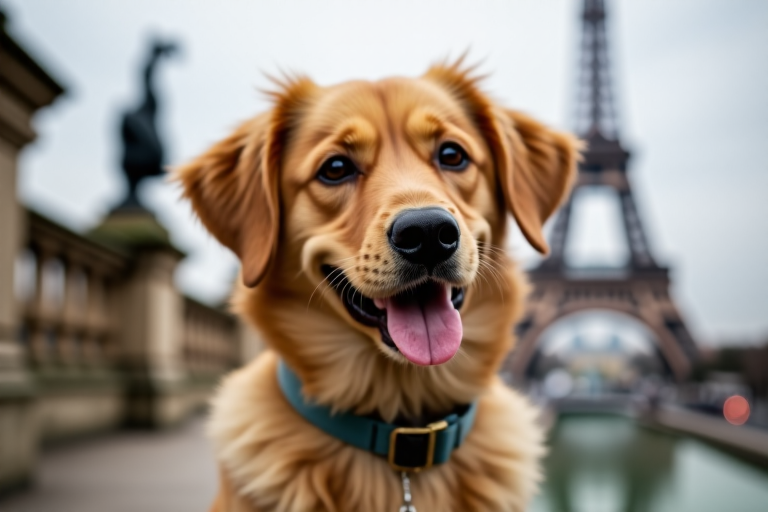

In [10]:
from PIL import Image

Image.open("output.png")

In [2]:
from transformers import T5EncoderModel
from diffusers import FluxPipeline, FluxTransformer2DModel

ckpt_4bit_id = "sayakpaul/flux.1-dev-nf4-pkg"
text_encoder_2_4bit = T5EncoderModel.from_pretrained(
    ckpt_4bit_id,
    subfolder="text_encoder_2",
)

transformer_4bit = FluxTransformer2DModel.from_pretrained(ckpt_4bit_id, subfolder="transformer")

def create_pipeline_for_text_embed(ckpt_id = "black-forest-labs/FLUX.1-dev"):
    pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    text_encoder_2=text_encoder_2_4bit,
    transformer=None,
    vae=None,
    torch_dtype=torch.float16,
    )
    pipeline.enable_model_cpu_offload()
    return pipeline

def create_pipeline_for_image(ckpt_id = "black-forest-labs/FLUX.1-dev"):
    pipeline = FluxPipeline.from_pretrained(
    ckpt_id,
    text_encoder=None,
    text_encoder_2=None,
    tokenizer=None,
    tokenizer_2=None,
    transformer=transformer_4bit,
    torch_dtype=torch.float16,
    )
    pipeline.enable_model_cpu_offload()
    return pipeline

c:\Users\Usuario\micromamba\envs\flux\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


In [3]:
def embed_prompt(pipeline, prompt: str):
    with torch.no_grad():
        print("Encoding prompts.")
        prompt_embeds, pooled_prompt_embeds, text_ids = pipeline.encode_prompt(
            prompt=prompt, prompt_2=None, max_sequence_length=256
        )

    pipeline = pipeline.to("cpu")
    del pipeline

    flush()

    return prompt_embeds, pooled_prompt_embeds

In [16]:
def generate_image(pipeline, prompt_embeds, pooled_prompt_embeds, height=512, width=768, num_inference_steps=25, guidance_scale=5.5):
    images = pipeline(
        prompt_embeds=prompt_embeds,
        pooled_prompt_embeds=pooled_prompt_embeds,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        height=height,
        width=width,
        output_type="pil",
    ).images

    flush()

    return images[0]

def save_image(image, path="output.png"):
    image.save(path)

In [34]:
pipeline_t = create_pipeline_for_text_embed()
prompt = "A white, enormous goblin in a bright cavern. The goblin is white-skinned, ugly and scary. He is fierce and stands tall. He has a small bag containing white sand attached to his body. Many runes and details about a magic world in the background"
prompt_embeds, pooled_prompt_embeds = embed_prompt(pipeline_t, prompt)
print(f"prompt_embeds shape: {prompt_embeds.shape}")
print(f"pooled_prompt_embeds shape: {pooled_prompt_embeds.shape}")

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.38it/s]


Encoding prompts.
prompt_embeds shape: torch.Size([1, 256, 4096])
pooled_prompt_embeds shape: torch.Size([1, 768])


In [35]:
pipeline_i = create_pipeline_for_image()
image = generate_image(pipeline_i, prompt_embeds, pooled_prompt_embeds)

flush()

100%|██████████| 25/25 [00:22<00:00,  1.09it/s]


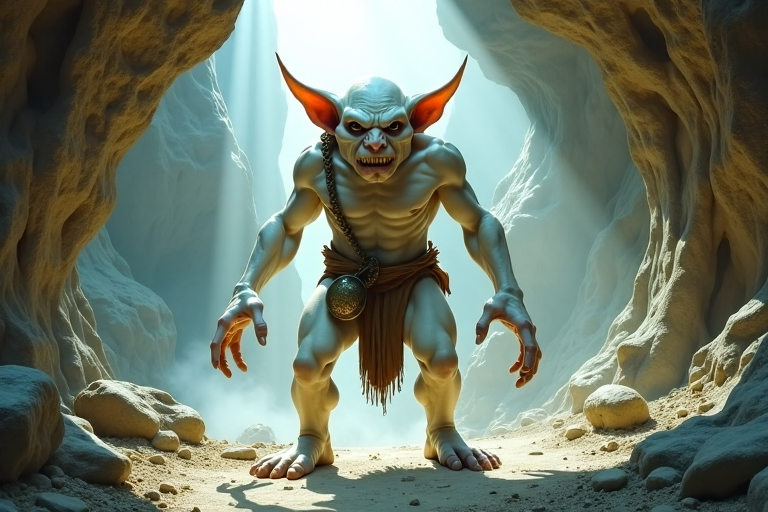

In [36]:
display(image)
save_image(image, "goblin_7.png")